# Lab 9 - Hierarchical Clustering

## Name and ID:
### Rom Amsili
### 

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jamessteve/categorized-news-articles
! unzip /content/categorized-news-articles.zip


  0% 0.00/2.88M [00:00<?, ?B/s]
100% 2.88M/2.88M [00:00<00:00, 135MB/s]
Archive:  /content/categorized-news-articles.zip
  inflating: news_articles.csv       


In [2]:
import pandas as pd

data = pd.read_csv('/content/news_articles.csv')
data = data.drop('url', axis=1)
data.head(10)

,category,body
0,business,easyjet and cruise firm carnival are to lose t...
1,business,british airways is in a bitter standoff with u...
2,business,us trade representative robert lighthizer the...
3,business,google adelie foods was hit by a drop in the ...
4,business,"matthew horwood some 300,000 more uk workers ..."
5,business,"a majority of investors, bankers and brokers w..."
6,business,house prices fell 1.7% in may from the previou...
7,business,david azia/oxfam oxfam has asked people to ca...
8,business,zoom zoom has become the app many are using t...
9,business,the drag on the us economy from the virus pand...


## Task 1:
Preprocess the articles using Doc2Vec embedding model with the parametes:

vector_size=100, window=5, min_count=1, workers=4

Fit doc2vec on the data and infer the vector for each article. 

See documentation of doc2vec model : https://radimrehurek.com/gensim/models/doc2vec.html

Explore the label distribution and perform dimensionality reduction using **Isomap** to plot the data points according to the label.

In [3]:
from nltk import tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
tokenized_docs = [word_tokenize(d.lower()) for d in data['body']]

tagged_data = [TaggedDocument(d, data['category'][i]) for i,d in enumerate(tokenized_docs)]

model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4)

X = [model.infer_vector(x) for x in tokenized_docs]
X[0]

array([ 0.00538555,  0.08899103, -0.4383415 , -0.8911173 ,  0.0595323 ,
       -0.831387  , -0.67906237,  0.35486162, -1.0981933 ,  0.8986538 ,
       -0.14908527, -0.07863333, -0.7904163 , -0.90181214,  1.4047463 ,
       -0.29157147, -0.19690685,  0.21226881, -0.34012347,  0.9388141 ,
        0.7185887 , -0.48966616,  1.3485988 ,  0.21555708,  1.4048163 ,
       -0.96773875, -0.7155747 ,  0.22244968, -0.45498055, -0.71084106,
        0.7216513 ,  1.6230918 , -0.5357794 ,  0.42341003, -0.7094095 ,
        0.34530306,  0.38828933,  0.30215946, -0.93087673, -0.15263237,
        0.00828571,  0.7984745 ,  1.0734763 , -0.06989896, -0.7514848 ,
       -0.06801994, -0.7892094 ,  0.1769166 ,  0.25857916, -1.341218  ,
       -1.4938291 , -0.46689275,  0.21462412,  0.3742462 , -0.00513501,
        0.59325284, -0.29346782, -0.11546468,  0.11940933,  1.1968201 ,
        0.18307471, -0.14190914,  0.7593612 , -0.5359421 ,  0.21597873,
       -0.53392226,  0.20899409,  0.27742013,  0.17238069,  0.71

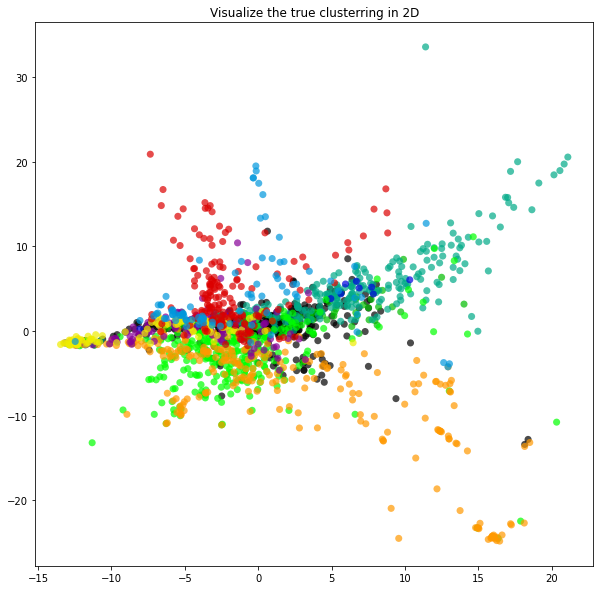

In [5]:
from sklearn.manifold import Isomap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y = le.fit_transform(data['category'])

reduction = Isomap(n_components=2, n_neighbors=7)
projected = reduction.fit_transform(X)

x = projected[:,0]
y = projected[:,1]

colors = cm.nipy_spectral(Y/10)

plt.figure(figsize=(10,10))
plt.scatter(x, y, s=50, lw=0, alpha=0.7, c=colors, edgecolors='k')
plt.title("Visualize the true clusterring in 2D")
plt.show()

## Task 2:
Create basic AgglomerativeClustering model with the parameters: n_clusters=10, affinity='cosine', linkage='complete', compute_distances=True

Plot the first 3 levels of dendrogram using the function 'plot_dendrogram' bellow with the parameters: truncate_mode="level", p=3. 
Find cutoff line for 10 clusters and plot it (using plt.axhline). This line represents the distance threshold.

plot the clustering of the model and the true clustering next to each other for visualize comparison

In [6]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [7]:
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(n_clusters=10, affinity='cosine', linkage='complete', compute_distances=True)
cluster_labels = clusterer.fit_predict(X)

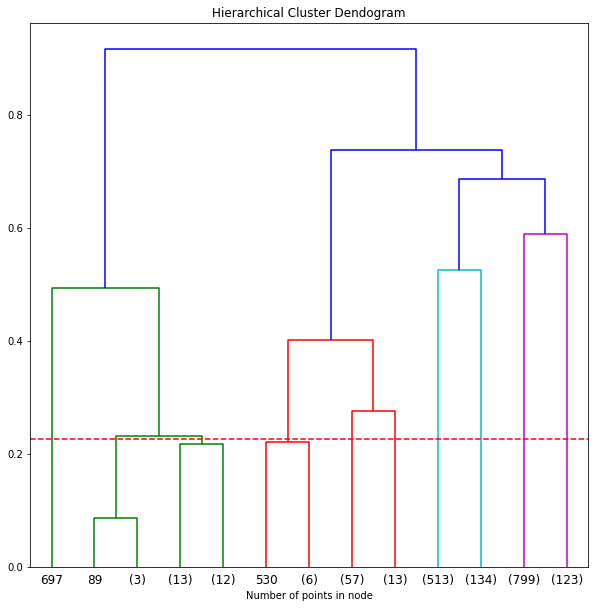

In [13]:
plt.figure(figsize=(10,10))
plt.title("Hierarchical Cluster Dendogram")
plot_dendrogram(clusterer, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")
plt.axhline(y=0.2267, color='r', linestyle='--')
plt.show()

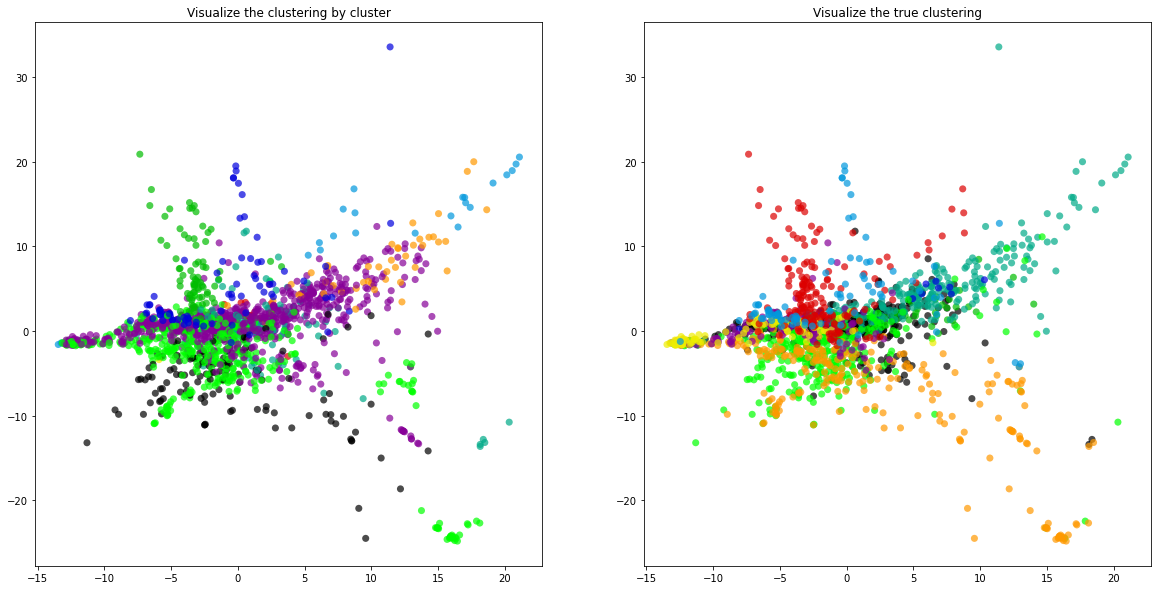

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

cluster_colors = cm.nipy_spectral(cluster_labels/10)

ax[0].scatter(projected[:,0], projected[:,1], s=50, lw=0, alpha=0.7, c=cluster_colors, edgecolor='k')
ax[0].set_title('Visualize the clustering by cluster')

y_color = cm.nipy_spectral(Y/10)

ax[1].scatter(projected[:,0], projected[:,1], s=50, lw=0, alpha=0.7, c=y_color, edgecolor='k')
ax[1].set_title('Visualize the true clustering')

plt.show()

## Task 3:
The Silhouette Coefficient is defined for each sample and is composed of two scores:

* a: The mean distance between a sample and all other points in the same cluster.

* b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample. The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Select **one** of the hyperparameters of the AgglomerativeClustering model, and try different values while saving the silhouette_score of each configuration. print the scores and the parameters that achieved it.

In [16]:
from sklearn.metrics import silhouette_score

print('silhouette_score: ',silhouette_score(X, clusterer.labels_))
metrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

silhouette = {}
for metric in metrics:
  clusterer = AgglomerativeClustering(n_clusters=10, affinity=metric, linkage='complete', compute_distances=True)
  clusterer.fit(X)
  silhouette[metric] = silhouette_score(X, clusterer.labels_)

silhouette

silhouette_score:  0.021661796


{'cosine': 0.021661796,
 'euclidean': 0.16551884,
 'l1': 0.25168884,
 'l2': 0.16551884,
 'manhattan': 0.25168884}

In [17]:
print(f"The best value of the hyperparameter 'affinity' is {silhouette['euclidean']}")

The best value of the hyperparameter 'affinity' is 0.1655188351869583


## Task 4:

Repeat Task 2 on a new AgglomerativeClustering model with the configuration that achieved the best silhouette_score

In [18]:
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='complete', compute_distances=True)
cluster_labels = clusterer.fit_predict(X)

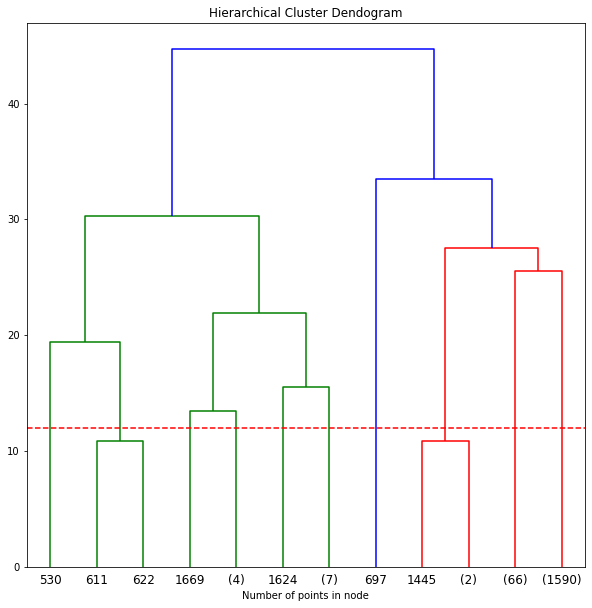

In [21]:
plt.figure(figsize=(10,10))
plt.title("Hierarchical Cluster Dendogram")
plot_dendrogram(clusterer, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")
plt.axhline(y=12, color='r', linestyle='--')
plt.show()

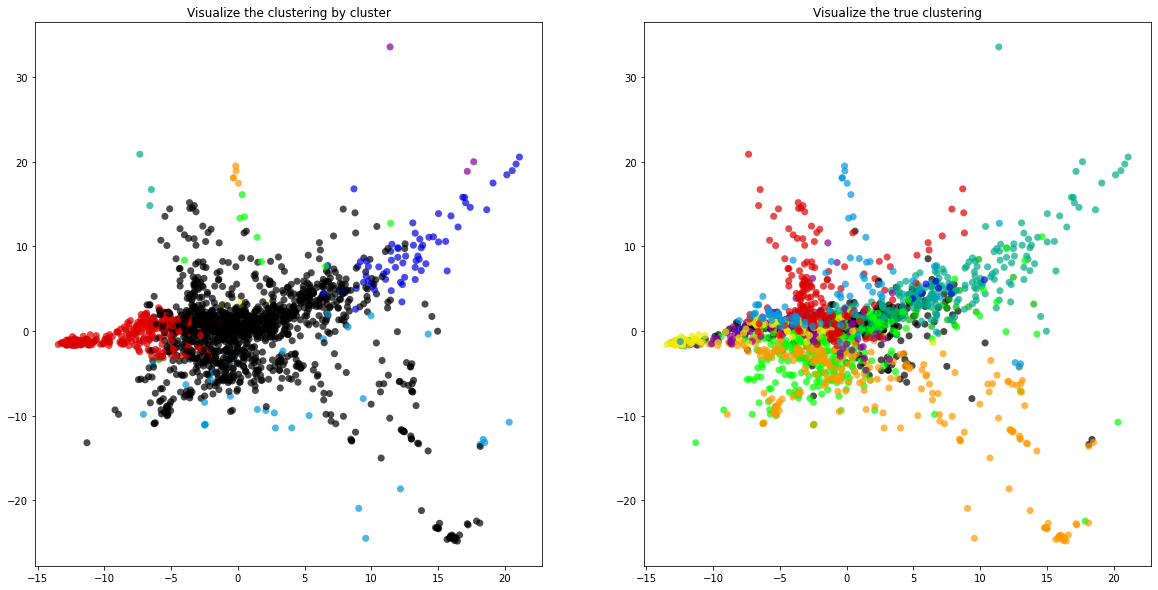

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

cluster_colors = cm.nipy_spectral(cluster_labels/10)

ax[0].scatter(projected[:,0], projected[:,1], s=50, lw=0, alpha=0.7, c=cluster_colors, edgecolor='k')
ax[0].set_title('Visualize the clustering by cluster')

y_color = cm.nipy_spectral(Y/10)

ax[1].scatter(projected[:,0], projected[:,1], s=50, lw=0, alpha=0.7, c=y_color, edgecolor='k')
ax[1].set_title('Visualize the true clustering')

plt.show()

## Task 5:
Convert the notebook into html:


1.   Download the notebook by clicking the File tab
2.   Upload it to this environment
3.   Run the command:

In [ ]:
%%shell
jupyter nbconvert --to html Lab9.ipynb